In [1]:
from pathlib import Path
import pickle

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from hp_pred.test_model import TestModel

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


## Load and format data

In [2]:
# import the data frame and add the meta data to the segments
dataset_name = '30_s_dataset'
model_filename = Path('xgb_30_s.json')

data = pd.read_parquet(Path(f'data/datasets/{dataset_name}/cases/'))

static = pd.read_parquet(f'data/datasets/{dataset_name}/meta.parquet')

data = data.merge(static, on='caseid')

## Evaluate model on the different Leading times


In [3]:
# control reproducibility
rng_seed = 42


leading_time_list = [2,3,4,5,6]
for leading_time in leading_time_list:
    data_lead = data[(data.time_before_IOH >= leading_time*60) | (data.time_before_IOH.isna())]

    test = data_lead[data_lead['split'] == "test"].copy()
    train = data_lead[data_lead['split'] == "train"].copy()

    print(f'leading time: {leading_time} minutes')
    print(
        f'{len(test)} test samples, positive rate = {test["label"].mean():.2%}'
    )

    tester = TestModel(
        test,
        train,
        [model_filename], # a list of model can be provided
        output_name=f'leading_time_{leading_time}_prediction',
    )

    tester.test_baseline()
    tester.test_model()
    print('\n')

leading time: 2 minutes
173776 test samples, positive rate = 7.34%
Number of points in the test data: 173776
Prevalence of hypotension: 7.34%
Test data loaded
Baseline test:


100%|██████████| 200/200 [04:04<00:00,  1.22s/it]


Model 0 test:


100%|██████████| 200/200 [02:03<00:00,  1.62it/s]




leading time: 3 minutes
172002 test samples, positive rate = 6.38%
Number of points in the test data: 172002
Prevalence of hypotension: 6.38%
Test data loaded
Baseline test:


100%|██████████| 200/200 [03:36<00:00,  1.08s/it]


Model 0 test:


100%|██████████| 200/200 [01:49<00:00,  1.83it/s]




leading time: 4 minutes
170322 test samples, positive rate = 5.46%
Number of points in the test data: 170322
Prevalence of hypotension: 5.46%
Test data loaded
Baseline test:


100%|██████████| 200/200 [03:06<00:00,  1.07it/s]


Model 0 test:


100%|██████████| 200/200 [01:27<00:00,  2.29it/s]




leading time: 5 minutes
168715 test samples, positive rate = 4.56%
Number of points in the test data: 168715
Prevalence of hypotension: 4.56%
Test data loaded
Baseline test:


100%|██████████| 200/200 [02:26<00:00,  1.36it/s]


Model 0 test:


100%|██████████| 200/200 [01:11<00:00,  2.78it/s]




leading time: 6 minutes
167199 test samples, positive rate = 3.69%
Number of points in the test data: 167199
Prevalence of hypotension: 3.69%
Test data loaded
Baseline test:


100%|██████████| 200/200 [01:53<00:00,  1.76it/s]


Model 0 test:


100%|██████████| 200/200 [00:56<00:00,  3.54it/s]

## Plot

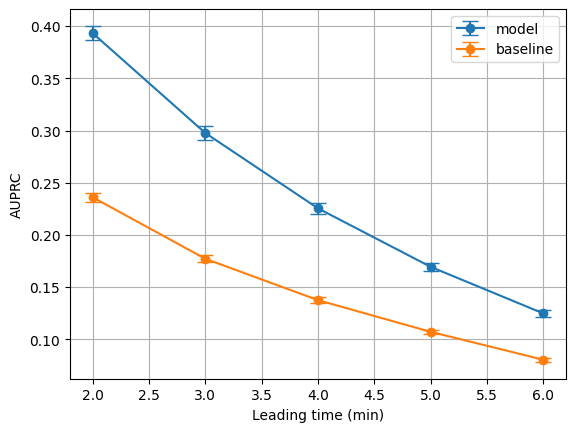

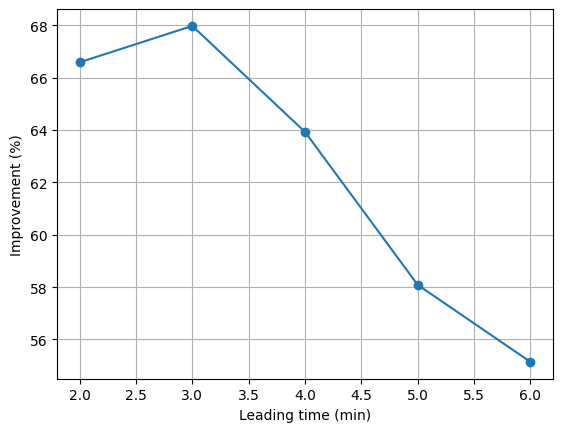

In [5]:
result_folder = Path("data/results")
xgboost_auc_list, baseline_auc_list, lead_time_list = [], [], []
xgboost_auc_std_list, baseline_auc_std_list = [], []
improvment = []
leading_time_list = [2,3,4,5,6]
for leading_time in leading_time_list:
    lead_time_list.append(leading_time)
    model_results = result_folder / f"{model_filename}_leading_time_{leading_time}_prediction.pkl"
    with model_results.open("rb") as f:
        dict_xgb = pickle.load(f)
    
    xgboost_auc_list.append(np.mean(dict_xgb['auprcs']))
    xgboost_auc_std_list.append(np.std(dict_xgb['auprcs']))


    baseline_results = result_folder / f"baseline_leading_time_{leading_time}_prediction.pkl"
    with baseline_results.open("rb") as f:
        dict_baseline = pickle.load(f)

    baseline_auc_list.append(np.mean(dict_baseline['auprcs']))
    baseline_auc_std_list.append(np.std(dict_baseline['auprcs']))

    improvment.append((xgboost_auc_list[-1] - baseline_auc_list[-1]) / baseline_auc_list[-1] * 100)
    

plt.errorbar(lead_time_list, xgboost_auc_list,xgboost_auc_std_list, fmt='-o', label='model', capsize=6)
plt.errorbar(lead_time_list, baseline_auc_list, baseline_auc_std_list, fmt='-o', label='baseline', capsize=6)
plt.xlabel('Leading time (min)')
plt.ylabel('AUPRC')
plt.grid()
plt.legend()
plt.show()

plt.plot(lead_time_list, improvment, '-o')
plt.xlabel('Leading time (min)')
plt.ylabel('Improvement (%)')
plt.grid()
plt.show()

#save the data
auc_df = pd.DataFrame({'lead_time': lead_time_list, 'xgboost_auc': xgboost_auc_list, 'xgboost_auc_std': xgboost_auc_std_list, 'baseline_auc': baseline_auc_list, 'baseline_auc_std': baseline_auc_std_list})
auc_df.to_csv(result_folder / 'auc_lead_time.csv', index=False)